In [461]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [459]:
df = yf.download(["GLD", "USO"], start="2006-04-04", end="2012-04-09", auto_adjust = True)
df = df["Close"]
df = df[4:]

[*********************100%***********************]  2 of 2 completed


In [455]:
x = df['GLD']
y = df['USO']

T = len(x)

In [457]:
# the prices are not co-integrated

stat, pval, crit = coint(y, x, trend="c", maxlag = 1, autolag = None)

print("Engle–Granger CADF via coint")
print("stat:", stat)
print("p-value:", pval)
print("crit:", crit)

Engle–Granger CADF via coint
stat: -1.5099627253403667
p-value: 0.7573519922870087
crit: [-3.90371244 -3.3401821  -3.0472618 ]


In [462]:
jres = coint_johansen(df, det_order = 0, k_ar_diff = 1)

print("Trace statistics:", jres.trace_stat)
print("Trace crit values (90,95,99%):\n", jres.trace_stat_crit_vals)

print("Max-eig statistics:", jres.max_eig_stat)
print("Max-eig crit values (90,95,99%):\n", jres.max_eig_stat_crit_vals)

Trace statistics: [4.50620696 0.70881782]
Trace crit values (90,95,99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-eig statistics: [3.79738915 0.70881782]
Max-eig crit values (90,95,99%):
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [463]:
lookback = 20 # obtained in hindsight

hedge_ratio = np.zeros(T)

hedge_ratio

array([0., 0., 0., ..., 0., 0., 0.], shape=(1510,))

In [464]:
i = lookback
xn = x[0 : lookback]
yn = y[0 : lookback]
xn = sm.add_constant(xn)
model = sm.OLS(yn, xn).fit()
model.params

const    532.300801
GLD        0.418342
dtype: float64

In [479]:
hedge_ratio = np.zeros(T)

for i in range(lookback, T + 1):
    yn = y[i - lookback: i]
    xn = x[i - lookback: i]
    xn = sm.add_constant(xn)
    model = sm.OLS(yn, xn).fit()
    hedge_ratio[i - 1] = model.params[1]

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_26525/1845511693.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio[i - 1] = model.params[1]
/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_26525/1845511693.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio[i - 1] = model.params[1]
/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_26525/1845511693.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

In [480]:
y2 = np.column_stack((x, y))
y2

array([[ 59.59999847, 544.15997314],
       [ 59.00999832, 545.59997559],
       [ 59.43000031, 542.7199707 ],
       ...,
       [159.88999939, 317.27999878],
       [157.21000671, 310.72000122],
       [158.30999756, 314.07998657]], shape=(1510, 2))

In [481]:
weights = np.column_stack((-hedge_ratio, np.ones(T)))
weights

array([[-0.        ,  1.        ],
       [-0.        ,  1.        ],
       [-0.        ,  1.        ],
       ...,
       [-0.86736313,  1.        ],
       [-1.27956671,  1.        ],
       [-1.45179752,  1.        ]], shape=(1510, 2))

In [482]:
yport = np.sum(weights * y2, axis = 1)
# yport = np.sum(np.multiply(y2, weights), axis = 1)
yport

array([544.15997314, 545.59997559, 542.7199707 , ..., 178.59730822,
       109.55931062,  84.24592407], shape=(1510,))

In [483]:
# re-adjust indeces
y2 = y2[lookback:]
yport = yport[lookback:]
hedge_ratio = hedge_ratio[lookback:]

## Spread = USO-hedgeRatio x GLD

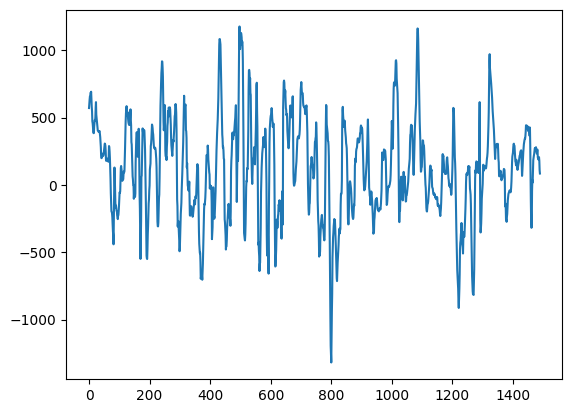

In [484]:
plt.plot(yport)

In [485]:
ma = pd.Series(yport).rolling(20).mean()
ma_std = pd.Series(yport).rolling(20).std()


zscore = (yport - ma ) / ma_std
zscore

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1485   -1.017931
1486   -0.885855
1487   -1.690158
1488   -2.805469
1489   -2.581268
Length: 1490, dtype: float64

In [486]:
num_units = -zscore
num_units

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1485    1.017931
1486    0.885855
1487    1.690158
1488    2.805469
1489    2.581268
Length: 1490, dtype: float64

In [487]:
sizes = np.column_stack((-hedge_ratio, np.ones_like(hedge_ratio)))
num_units = num_units.values.reshape(len(num_units), -1) # reshape
positions = (num_units * sizes) * y2
positions

array([[          nan,           nan],
       [          nan,           nan],
       [          nan,           nan],
       ...,
       [-234.39561849,  536.25323572],
       [-564.35014444,  871.71542831],
       [-593.26321713,  810.7244907 ]], shape=(1490, 2))

In [488]:
pos = pd.DataFrame(positions.copy())
pos_lag = pos.shift(1)

prices = pd.DataFrame(y2.copy())
prices_lag = prices.shift(1)

pnl = np.sum(pos_lag * (prices - prices_lag) / prices_lag, axis = 1)
pnl

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1485   -0.323757
1486    5.851629
1487   -0.723860
1488   -7.158613
1489    5.477605
Length: 1490, dtype: float64

In [489]:
ret = pnl / np.abs(pos_lag).sum(axis = 1)
ret = ret[~np.isnan(ret)]
APR = np.prod(1 + ret) ** (252 / len(ret)) - 1
APR

np.float64(0.11698760789636675)

## Bollinger Bands

In [490]:
df

Ticker,GLD,USO
Date,,
2006-04-10,59.599998,544.159973
2006-04-11,59.009998,545.599976
2006-04-12,59.430000,542.719971
2006-04-13,59.500000,550.559998
2006-04-17,61.090000,558.320007
...,...,...
2012-03-30,162.119995,313.839996
2012-04-02,162.940002,320.239990
2012-04-03,159.889999,317.279999


In [491]:
entry_score = 1
exit_score = 0

In [492]:
long_entry = zscore < -entry_score
long_exit = zscore >  -exit_score

short_entry = zscore > entry_score
short_exit = zscore < exit_score


In [493]:
num_long = np.full((len(yport), 1), np.nan)
num_short = np.full((len(yport), 1), np.nan)

In [494]:
num_long[0] = 0
num_long[long_entry] = 1
num_long[long_exit] = 0
num_long = pd.DataFrame(num_long)
num_long.fillna(method = "ffill", inplace = True)

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_26525/2633109375.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  num_long.fillna(method = "ffill", inplace = True)


In [495]:
num_short[0] = 0
num_short[short_entry] = -1
num_short[short_exit] = 0
num_short = pd.DataFrame(num_short)
num_short.fillna(method = "ffill", inplace = True)

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_26525/2109170659.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  num_short.fillna(method = "ffill", inplace = True)


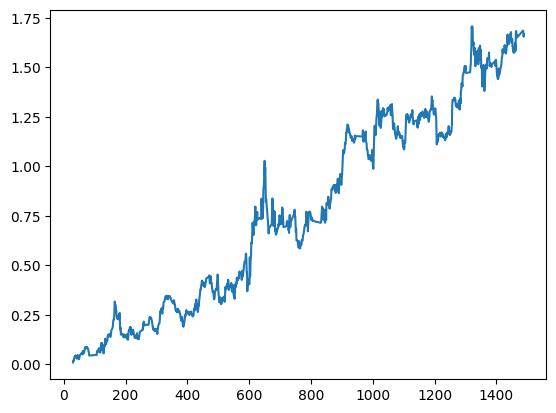

In [496]:
num_units = num_long + num_short
num_units = np.repeat(num_units, y2.shape[1], axis=1)

sizes = np.column_stack((-hedge_ratio, np.ones_like(hedge_ratio)))
positions = (num_units * sizes) * y2
pos = pd.DataFrame(positions.copy())
pos_lag = pos.shift(1)

prices = pd.DataFrame(y2.copy())
prices_lag = prices.shift(1)

pnl = np.sum(pos_lag * (prices - prices_lag) / prices_lag, axis = 1)
ret = pnl / np.abs(pos_lag).sum(axis = 1)
ret = ret[~np.isnan(ret)]

cum_ret = np.cumprod(1 + ret) - 1
plt.plot(cum_ret)

In [497]:
APR = np.prod(1 + ret) ** (252 / len(ret)) - 1
APR

np.float64(0.24078329911702112)

In [498]:
SR = np.sqrt(252) * np.mean(ret) / np.std(ret)
SR

np.float64(1.1150857799825966)

# TODOS
- Clean code
- Figure out where to go long and where to go short